<a href="https://colab.research.google.com/github/eebjwa/SENSE_week2_team4/blob/main/CorineClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This will be our sentinel processing script
# Import earthengine API
import ee
# Authenticate and initialise 
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=j8Vwj90VEOSYvrPkJPNPa7hd0pxKITmJAsycFoxxRkQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AfDhmrhqITOvkClY_W4Z-wbbxmVlKv4SXl10sXN5Q5p4DPrLDfh3sNq0GY8

Successfully saved authorization token.


In [ ]:
def ESAcloudMask(img):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
     
    parsed by Nick Clinton
    """

    qa = img.select('QA60')

    # bits 10 and 11 are clouds and cirrus
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # both flags set to zero indicates clear conditions.
    clear = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    # clouds is not clear
    cloud = clear.Not().rename(['ESA_clouds'])

    # return the masked and scaled data.
    return img.addBands(cloud)

In [ ]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR")
sample_image = S2.filterBounds(ee.Geometry.Point(-71.0, 19.0)).sort('CLOUDY_PIXEL_PERCENTAGE').first()
#sample_image.getInfo()



In [ ]:
import folium
!pip install geehydro # Life saver for plotting GEE stuff with Python!
import geehydro

cloudmasked_image = ESAcloudMask(sample_image)

map = folium.Map(location=[19.0,-71.0],zoom_start=9)
map.addLayer(cloudmasked_image,{'min':0,'max':2000,'bands':['B4','B3','B2']},'rbg')
map.addLayer(cloudmasked_image,{'min':0,'max':1,'bands':['ESA_clouds']},'cloud')
folium.LayerControl().add_to(map)
map

In [ ]:
dataset = ee.Image('COPERNICUS/CORINE/V20/100m/2012');
landCover = dataset.select('landcover');

class_vals = landCover.get('landcover_class_values').getInfo()
new_classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]

In [ ]:
#train a classifier on the corine europe data set using Sentinel 2
training_image = S2.filterBounds(ee.Geometry.Point(11.4, 52.58)).sort('CLOUDY_PIXEL_PERCENTAGE').first()
roi = training_image.geometry()
#roi = ee.Geometry.Rectangle([10.4,52.0,12.5,53.5])
bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

Corine_image = ee.ImageCollection("COPERNICUS/CORINE/V20/100m").first().clip(roi)
print(Corine_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'landcover', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [1114, 1115], 'origin': [34527, 21518], 'crs': 'EPSG:3035', 'crs_transform': [100, 0, 900000, 0, -100, 5500000]}], 'version': 1578598780904750.0, 'id': 'COPERNICUS/CORINE/V20/100m/1990', 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[10.498311684940601, 53.24022144136133], [10.498310096877374, 53.240210194266425], [10.481330902645995, 52.74694683749759], [10.464839355506658, 52.25363837685264], [10.464897697516808, 52.25359618861587], [10.464946974263627, 52.253549810234745], [10.464970995439522, 52.253546760776516], [12.071392282770864, 52.222663254451206], [12.071462488400046, 52.22269809173016], [12.07153922101501, 52.22272723646142], [12.07154477163714, 52.22274187616376], [12.106073710388985, 52.71550611678274], [12.141620986961303, 53.20820529889366], [12.14156306828504, 53.20824830620467], [12.141514516416946

In [ ]:
Corine_coll = ee.ImageCollection("COPERNICUS/CORINE/V20/100m")
Pal = Corine_coll.select('landcover').get('landcover_class_palette')
Pal_names = Corine_coll.get('landcover_class_names')

In [ ]:
Corine_image_remapped = Corine_image.remap(class_vals, new_classes, 999, 'landcover')
print(Corine_image.getInfo())

combined_image = ee.ImageCollection([training_image.select(bands),Corine_image])

randomPoints = ee.FeatureCollection.randomPoints(roi,10000);
#print(randomPoints.getInfo())
label = 'remapped'

#
Corine_samples = Corine_image_remapped.sampleRegions(randomPoints,geometries=True)
S2_samples = training_image.select(bands).sampleRegions(Corine_samples)
#print(Corine_samples.getInfo())
#print(S2_samples.getInfo())
#print(Corine_samples.getInfo())

#training = training_image.select(bands).sampleRegions(Corine_samples,properties =[label],scale=100)

# Make a CART Classifier and train it 
trained = ee.Classifier.smileCart().train(S2_samples, label, bands)

#Classify the input imagery 
classified = training_image.select(bands).classify(trained)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trained.confusionMatrix()
#print('Resubstitution error matrix: ', trainAccuracy.getInfo())
#print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())


{'type': 'Image', 'bands': [{'id': 'landcover', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [1114, 1115], 'origin': [34527, 21518], 'crs': 'EPSG:3035', 'crs_transform': [100, 0, 900000, 0, -100, 5500000]}], 'version': 1578598780904750.0, 'id': 'COPERNICUS/CORINE/V20/100m/1990', 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[10.498311684940601, 53.24022144136133], [10.498310096877374, 53.240210194266425], [10.481330902645995, 52.74694683749759], [10.464839355506658, 52.25363837685264], [10.464897697516808, 52.25359618861587], [10.464946974263627, 52.253549810234745], [10.464970995439522, 52.253546760776516], [12.071392282770864, 52.222663254451206], [12.071462488400046, 52.22269809173016], [12.07153922101501, 52.22272723646142], [12.07154477163714, 52.22274187616376], [12.106073710388985, 52.71550611678274], [12.141620986961303, 53.20820529889366], [12.14156306828504, 53.20824830620467], [12.141514516416946

In [ ]:
#VALIDATION 

randomPointsVal = ee.FeatureCollection.randomPoints(roi,10000, 2);
#print(randomPoints.getInfo())
label = 'remapped'

Validation_samples = Corine_image_remapped.sampleRegions(randomPointsVal,geometries=True)
S2_Val_Samples = training_image.select(bands).sampleRegions(Validation_samples)
#print(Corine_samples.getInfo())
#print(S2_samples.getInfo())
#print(Corine_samples.getInfo())

#training = training_image.select(bands).sampleRegions(Corine_samples,properties =[label],scale=100)

validated = S2_Val_Samples.classify(trained)
#print(validated.getInfo())




In [ ]:
# Get a confusion matrix representing resubstitution accuracy.
ValAccuracy = validated.errorMatrix('remapped', 'classification')
#print('Validation error matrix: ', ValAccuracy.getInfo())
print('Validation overall accuracy: ', ValAccuracy.accuracy().getInfo())

Validation overall accuracy:  0.6135067533766884


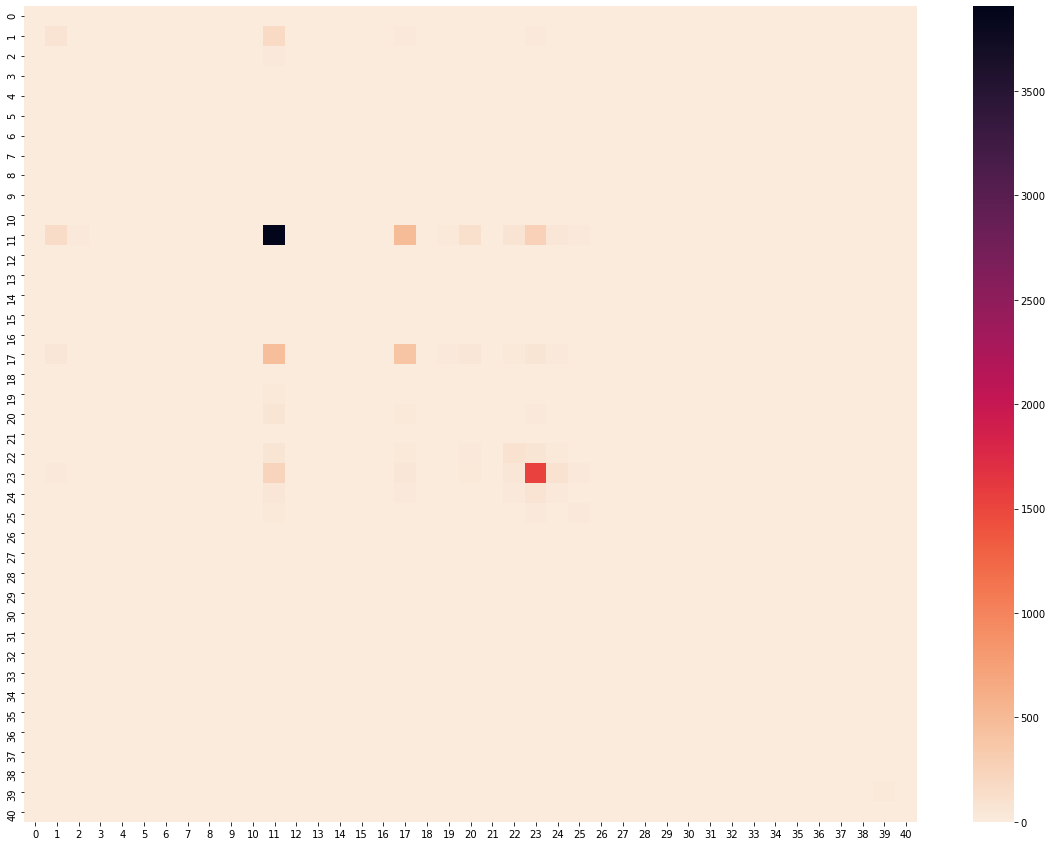

In [ ]:
#Make pretty confusion matrix 
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


array = ValAccuracy.getInfo()
df_cm = pd.DataFrame(array)
plt.figure(figsize = (20,15))
#set color map 
cmap = sn.cm.rocket_r
matrix = sn.heatmap(df_cm, cmap=cmap)
fig=matrix.get_figure()
fig.savefig("error_matrix.png")


In [ ]:
dataset = ee.Image('COPERNICUS/CORINE/V20/100m/2012');
landCover = dataset.select('landcover');

print(landCover.get('landcover_class_palette').getInfo())

['E6004D', 'FF0000', 'CC4DF2', 'CC0000', 'E6CCCC', 'E6CCE6', 'A600CC', 'A64DCC', 'FF4DFF', 'FFA6FF', 'FFE6FF', 'FFFFA8', 'FFFF00', 'E6E600', 'E68000', 'F2A64D', 'E6A600', 'E6E64D', 'FFE6A6', 'FFE64D', 'E6CC4D', 'F2CCA6', '80FF00', '00A600', '4DFF00', 'CCF24D', 'A6FF80', 'A6E64D', 'A6F200', 'E6E6E6', 'CCCCCC', 'CCFFCC', '000000', 'A6E6CC', 'A6A6FF', '4D4DFF', 'CCCCFF', 'E6E6FF', 'A6A6E6', '00CCF2', '80F2E6', '00FFA6', 'A6FFE6', 'E6F2FF']


In [ ]:
landcover_vis = {'palette':['E6004D', 'FF0000', 'CC4DF2', 'CC0000', 'E6CCCC', 'E6CCE6', 'A600CC', 'A64DCC', 'FF4DFF', 'FFA6FF', 'FFE6FF', 'FFFFA8', 'FFFF00', 'E6E600', 'E68000', 'F2A64D', 'E6A600', 'E6E64D', 'FFE6A6', 'FFE64D', 'E6CC4D', 'F2CCA6', '80FF00', '00A600', '4DFF00', 'CCF24D', 'A6FF80', 'A6E64D', 'A6F200', 'E6E6E6', 'CCCCCC', 'CCFFCC', '000000', 'A6E6CC', 'A6A6FF', '4D4DFF', 'CCCCFF', 'E6E6FF', 'A6A6E6', '00CCF2', '80F2E6', '00FFA6', 'A6FFE6', 'E6F2FF']}
#class_vals = landCover.get('landcover_class_values').getInfo()
#new_classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]

In [ ]:
map = folium.Map(location=[52.58,11.4],zoom_start=9)

#roi = ee.Geometry.Rectangle([10.5,52,12.5,53.5])

map.addLayer(training_image, {'min':0,'max':2000,'bands': ['B4', 'B3', 'B2']}, 'image')
map.addLayer(Corine_image.select('landcover'), {}, 'landcover')
map.addLayer(randomPoints, {}, 'random points')
map.addLayer(classified,landcover_vis,'classification')
folium.LayerControl().add_to(map)
map

EEException: ignored

In [ ]:

#Get composite image of S2 imagery over Hispianiola between jan-mar 2020 (filtered to cloud % <10)
HispComposite = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(ee.Geometry.Polygon(
        [[[-74.60668900677238, 20.088333497505946],
          [-74.60668900677238, 17.687361057873034],
          [-68.11376908489738, 17.687361057873034],
          [-68.11376908489738, 20.088333497505946]]])).filterDate('2020-01-10', '2020-03-20').filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)

#Get median image from the image collection (to reduce cloud impact)
HispCompositeMed = HispComposite.median()

#Run classification over whole island 
Hisp_classified = HispCompositeMed.select(bands).classify(trained)

#Define individual ROIs for Haiti and DR 
Haiti_roi = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na', 'Haiti'))
DR_roi = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na', 'Dominican Republic'))

#Clip classified image to each country (Haiti and DR)
Haiti_classified = Hisp_classified.clip(Haiti_roi)
DR_classified = Hisp_classified.clip(DR_roi)

#sample_image.getInfo()
map = folium.Map(location=[19.0,-71.0],zoom_start=9)
map.addLayer(sample_image,{'min':0,'max':2000,'bands':['B4','B3','B2']},'rbg')
map.addLayer(HispCompositeMed, {'min':0,'max':2000,'bands':['B4','B3','B2']},'Hispaniola_med')
map.addLayer(classified.randomVisualizer(), {}, 'classified_hisp')
#map.addLayer(Haiti_classified.remap(class_vals, new_classes), {'min':0, 'max':43, 'palette':landcover_vis['palette']}, 'classified_Haiti')
#map.addLayer(DR_classified.remap(class_vals, new_classes), {'min':0, 'max':43, 'palette':landcover_vis['palette']}, 'classified_DR')
map.addLayer(Haiti_classified, {'min':0, 'max':43, 'palette':landcover_vis['palette']}, 'classified_Haiti')
map.addLayer(DR_classified, {'min':0, 'max':43, 'palette':landcover_vis['palette']}, 'classified_DR')
folium.LayerControl().add_to(map)
map

In [ ]:
#Validate the classifier against the europe data set

In [ ]:
# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trained.confusionMatrix()
print('Resubstitution error matrix: ', trainAccuracy.getInfo())
print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())

Resubstitution error matrix:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#run the classifier on a single image on hispaniola to sense-check

In [ ]:
#create a collection of classified images from sentinel from 2016 to now

In [ ]:
#make pretty plots